In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image
import os
import pandas as pd
import requests
from io import BytesIO
import PIL
import matplotlib.pyplot as plt

In [3]:
# Load and Use the Saved Model for Prediction

In [5]:
# Load the saved model
model = tf.keras.models.load_model("cat_dog_classifier.h5")

In [7]:
# Function to predict image
def predict_image(image_path):
    img = Image.open(image_path).resize((128, 128))
    img_array = np.array(img) / 255.0

    if img_array.shape[-1] != 3:
        img_array = np.stack((img_array,)*3, axis=-1)  # Ensure 3 channels

    img_array = img_array.reshape(1, 128, 128, 3)

    prediction = model.predict(img_array)[0][0]
    label = "dog" if prediction > 0.5 else "cat"
    print(f"Prediction: {label} ({prediction:.2f})")
    #print(f" {image} ({prediction:.2f})")
    return label
    

In [9]:
# Example usage:
predict_image("./cats and dogs/cat.4005.jpg")

Prediction: cat (0.09)


'cat'

In [ ]:
# bulk predictions and generation of metrics

In [13]:
def bulk_predict():
    predictions = []
    for image in os.listdir('cats and dogs'):
        try:
            predictions.append(image + " -- " + predict_image('./cats and dogs/' + image)) 
        except:
            pass
    df = pd.DataFrame(predictions)
    cols = ['Prediction']
    df.columns = cols
    df['Match'] = df['Prediction'].apply(lambda x: x[:3] == x[-3:])
    df['catdog']=df['Prediction'].apply(lambda x: x[:3])
    counts = df['catdog'].value_counts()
    pairs = df[['Match','catdog']].value_counts().reset_index(name='count')
    cats = df[df['catdog'] == 'cat']['catdog'].value_counts()
    dogs = df[df['catdog'] == 'dog']['catdog'].value_counts()
    true_cats = df[(df['Match']==True) & (df['catdog']=='cat')]
    good_cats = true_cats.groupby(['Match','catdog']).size().reset_index(name='count')
    true_dogs = df[(df['Match']==True) & (df['catdog']=='dog')]
    good_dogs = true_dogs.groupby(['Match','catdog']).size().reset_index(name='count')
    cat_match_rate = good_cats['count']/cats
    cat_accuracy = str((list(good_cats['count'])[0]/list(cats)[0])*100)[:5] + '%'
    dog_match_rate = good_dogs['count']/dogs
    dog_accuracy = str((list(good_dogs['count'])[0]/list(dogs)[0])*100)[:5] + '%'
    print("Cat accuracy rate: " + cat_accuracy)
    print("Dog accuracy rate: " + dog_accuracy)
    return df

In [15]:
def predict_from_url(url):

    #url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSRDAweol22xgaIp11nN8TlbAS0tJp304XTJQ&s"

    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = img.resize((128, 128))
    img_array = np.array(img)/255.0
    img_tensor = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_tensor)
    if pred.shape[-1] == 1:
        label = "Dog" if pred[0][0] > 0.5 else "Cat"
    else:
        label = ["Cat", "Dog"][np.argmax(pred)]
    image = process_image_from_url(url)
    if image:
        display_image(image)
        print(f"Prediction: {label} (raw: {pred})")

In [19]:
def process_image_from_url(image_url):
    """
    Fetches an image from a URL and processes it.

    Args:
        image_url (str): The URL of the image.

    Returns:
        PIL.Image.Image: The processed image object, or None if an error occurs.
    """
    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        image = Image.open(BytesIO(response.content))
        return image
    except requests.exceptions.RequestException as e:
        print(f"Error fetching image: {e}")
        return None
    except Exception as e:
         print(f"Error processing image: {e}")
         return None

def display_image(image):
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()


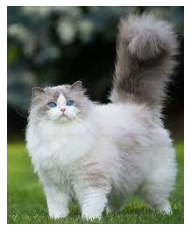

Prediction: Cat (raw: [[0.00303084]])


In [23]:
predict_from_url("""


https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQlVmWx_a9nyJ6jswOCP2NxeCCrIgj7VEPEL9k4cSLJxyTqsN4aqziW5ze6N4hLkBqmJws&usqp=CAU

""")